In [6]:
import torch, torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import time
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import os

from PIL import Image
import image_classification_tools

In [7]:
image_transforms = image_classification_tools.make_transforms()

In [8]:
# Load the Data

# Set train and valid directory paths

dataset = ''

train_directory = os.path.join(dataset, 'train')
valid_directory = os.path.join(dataset, 'valid')
test_directory = os.path.join(dataset, 'test')

# Batch size
bs = 32

# Number of classes
num_classes = len(os.listdir(valid_directory))-1
print(num_classes)

# Load Data from folders
data = {
    'train': datasets.ImageFolder(root=train_directory, transform=image_transforms['train']),
    'valid': datasets.ImageFolder(root=valid_directory, transform=image_transforms['valid']),
    'test': datasets.ImageFolder(root=test_directory, transform=image_transforms['test'])
}

# Get a mapping of the indices to the class names, in order to see the output classes of the test images.
idx_to_class = {v: k for k, v in data['train'].class_to_idx.items()}
print(idx_to_class)

# Size of Data, to be used for calculating Average Loss and Accuracy
train_data_size = len(data['train'])
valid_data_size = len(data['valid'])
test_data_size = len(data['test'])

# Create iterators for the Data loaded using DataLoader module
train_data_loader = DataLoader(data['train'], batch_size=bs, shuffle=True)
valid_data_loader = DataLoader(data['valid'], batch_size=bs, shuffle=True)
test_data_loader = DataLoader(data['test'], batch_size=bs, shuffle=True)

4
{0: 'abstract', 1: 'collage', 2: 'hand', 3: 'photo'}


In [9]:
train_data_size, valid_data_size, test_data_size

(297, 100, 99)

In [10]:
# Load pretrained ResNet50 Model
resnet50 = models.resnet50(pretrained=True)

In [11]:
# Freeze model parameters
for param in resnet50.parameters():
    param.requires_grad = False

In [12]:
# Change the final layer of ResNet50 Model for Transfer Learning
fc_inputs = resnet50.fc.in_features

resnet50.fc = nn.Sequential(
    nn.Linear(fc_inputs, 256),
    nn.ReLU(),
    nn.Dropout(0.4),
    nn.Linear(256, num_classes), # Since 10 possible outputs
    nn.LogSoftmax(dim=1) # For using NLLLoss()
)

In [13]:
# Define Optimizer and Loss Function
loss_func = nn.NLLLoss()
optimizer = optim.Adam(resnet50.parameters())

In [14]:
# Train the model for 20 epochs
num_epochs = 20
trained_model, history = image_classification_tools.train_and_validate(resnet50, loss_func, optimizer,
                                                                      train_data_loader,valid_data_loader,train_data_size,
                                                                       valid_data_size,num_epochs)

torch.save(history, dataset+'_history.pt')

Epoch: 1/20
Epoch : 000, Training: Loss: 1.3217, Accuracy: 39.0572%, 
		Validation : Loss : 0.9938, Accuracy: 56.0000%, Time: 103.7987s
Epoch: 2/20
Epoch : 001, Training: Loss: 0.9481, Accuracy: 61.6162%, 
		Validation : Loss : 0.7645, Accuracy: 80.0000%, Time: 103.7228s
Epoch: 3/20
Epoch : 002, Training: Loss: 0.8618, Accuracy: 65.6566%, 
		Validation : Loss : 0.6623, Accuracy: 78.0000%, Time: 105.3230s
Epoch: 4/20
Epoch : 003, Training: Loss: 0.6946, Accuracy: 74.0741%, 
		Validation : Loss : 0.6031, Accuracy: 80.0000%, Time: 101.2640s
Epoch: 5/20
Epoch : 004, Training: Loss: 0.6980, Accuracy: 70.3704%, 
		Validation : Loss : 0.7548, Accuracy: 70.0000%, Time: 100.1971s
Epoch: 6/20
Epoch : 005, Training: Loss: 0.7257, Accuracy: 68.3502%, 
		Validation : Loss : 0.5687, Accuracy: 81.0000%, Time: 98.9793s
Epoch: 7/20
Epoch : 006, Training: Loss: 0.6053, Accuracy: 75.0842%, 
		Validation : Loss : 0.5346, Accuracy: 82.0000%, Time: 104.4076s
Epoch: 8/20
Epoch : 007, Training: Loss: 0.6128, 

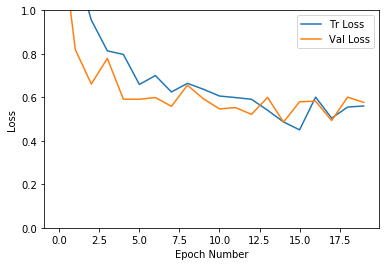

In [11]:
history = np.array(history)
plt.plot(history[:,0:2])
plt.legend(['Tr Loss', 'Val Loss'])
plt.xlabel('Epoch Number')
plt.ylabel('Loss')
plt.ylim(0,1)
plt.savefig(dataset+'_loss_curve.png')
plt.show()


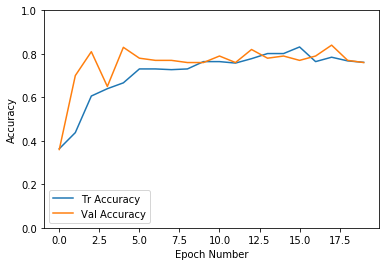

In [12]:
plt.plot(history[:,2:4])
plt.legend(['Tr Accuracy', 'Val Accuracy'])
plt.xlabel('Epoch Number')
plt.ylabel('Accuracy')
plt.ylim(0,1)
plt.savefig(dataset+'_accuracy_curve.png')
plt.show()

Prediction 1 : hand , Score:  0.6855115
Prediction 2 : photo , Score:  0.20885837
Prediction 3 : collage , Score:  0.095827274
2


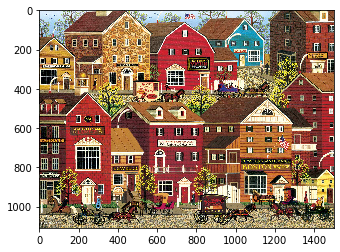

In [16]:
# Test a particular model on a test image

dataset = ''
model = torch.load('_model_17.pt')
x = image_classification_tools.predict(model, 'new_ims/42.jpg',image_transforms,idx_to_class,silent=False)
print(x)
# Load Data from folders
# all_predictions = computeTestSetAccuracy(model, loss_func) 

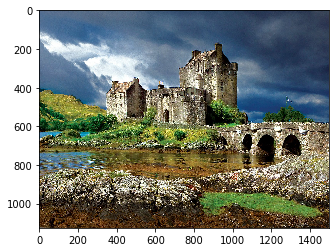

In [17]:
# Do the predictions for the whole dataset
import glob

cats = ['abstract','collage','hand','photo']
n_classes = len(cats)

y_probs = []
y_preds = []
y_train = []
model = torch.load('models/best_model_art_style_4cat.pt')
n_classes = len(idx_to_class.keys())
cats = [idx_to_class[ix] for ix in range(n_classes)]
for ix,wdir in enumerate(cats):
    ims = []
    ims.extend(glob.glob('test/'+wdir+'/*.jpg'))
    ims.extend(glob.glob('valid/'+wdir+'/*.jpg'))
    ims.extend(glob.glob('storage/'+wdir+'/*.jpg'))
    for im in ims[:50]:
        # Get the score as well
        preds,scores = image_classification_tools.predict(model, im,image_transforms,idx_to_class,silent=True,return_scores=True)
        x = np.zeros(n_classes)
        x[preds] = scores
        y_probs.append(x)
        y_preds.append(preds[0])
        y_train.append(ix)
#         pass
#     print(len(ims))

In [18]:
# Assume hand-drawn if prob > 0.4
# y_probs = np.array(y_probs)
# y_preds = np.argmax(y_probs,axis=1)
# y_preds[y_probs[:,2] > 0.4] = 2
# y_preds[y_probs[:,0] > 0.5] = 0
# print(p[0:20])
# print(y_preds[0:20])
# print(y_train[0:20])
# print(np.max(y_preds))
print(len(y_train))

160


Accuracy: 0.78125


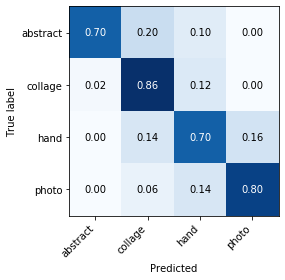

F1 score: 0.7800556586270873


In [19]:
# Make a confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix,f1_score

print('Accuracy:',accuracy_score(y_train,y_preds))
# And a confusion matrix
conf_matrix = confusion_matrix(y_train,y_preds)
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

# Plot it
image_classification_tools.plot_confusion_matrix(conf_matrix,cats=cats)#,save='conf_matrix_artstyle.png')

# What is the F1 score
print('F1 score:',f1_score(y_train,y_preds,average='macro'))

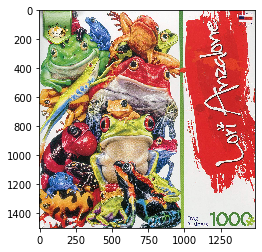

In [129]:
# Do the predictions for the whole dataset of images
import glob,shutil

y_preds = []
y_train = []
model = torch.load('models/best_model_art_style_4cat.pt')
n_classes = len(idx_to_class.keys())
cats = [idx_to_class[ix] for ix in range(n_classes)]

ims = glob.glob('new_ims/*.jpg')

for ix,im in enumerate(ims[0:1000]):
    cat_pred = image_classification_tools.predict(model, im,image_transforms,idx_to_class,silent=True)
    new_fn = 'new_ims/'+cats[cat_pred]+'/'+im.split('/')[-1]
    shutil.move(im,new_fn)

In [176]:
clean_df = pd.read_csv('../clean_product_df.csv')

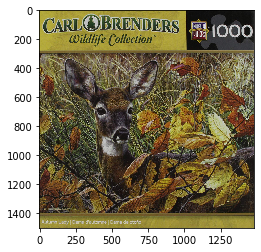

In [280]:
# Do the predictions for the whole dataset of clean data!
import pandas as pd
import glob,shutil

clean_df = pd.read_csv('../clean_product_df.csv')

y_preds = []
y_train = []
model = torch.load('models/best_model_art_style_4cat.pt')
idx_to_class = {0: 'abstract', 1: 'collage', 2: 'hand', 3 : 'photo'}

n_classes = len(idx_to_class.keys())
cats = [idx_to_class[ix] for ix in range(n_classes)]

cat_preds = []
for ix in range(clean_df.shape[0]):
    prod_ix = clean_df['product_index'][ix]
    ims = glob.glob('*/*/'+str(prod_ix-1)+'.jpg')
    ims.extend(glob.glob('*/'+str(prod_ix-1)+'.jpg'))
    
    if len(ims) < 1:
        print('Didnt find image:',prod_ix,'for puzzle',clean_df['name'][ix])
        cat_preds
        continue
    im = ims[0]
    
    cat_pred = image_classification_tools.predict(model, im,image_transforms,idx_to_class,silent=True)
    cat_preds.append(cat_pred)
    
    new_fn = 'final_sort/'+cats[cat_pred]+'/'+im.split('/')[-1]
#     print(new_fn)
    if im != new_fn:
        shutil.copy2(im,new_fn)


In [281]:
cat_preds = np.array(cat_preds)
cat_preds_name = []
for ix,p in enumerate(cat_preds):
    cat_preds_name.append(idx_to_class[p])
print(len(cat_preds_name))
print(clean_product_df.shape)

# Add the csv file
clean_product_df = pd.read_csv('../clean_product_df.csv')
clean_product_df['art_style'] = cat_preds_name
clean_product_df.to_csv('../clean_product_df.csv')

624
(253, 28)
